In [156]:
import os
import time
import math
import pickle
from contextlib import nullcontext
import socket
import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

from model_tmax import GPTConfig, GPT

import warnings
from typing import Union, Iterable, List, Dict, Tuple, Optional

import torch
from torch import Tensor, inf
from torch.utils._foreach_utils import _group_tensors_by_device_and_dtype, _has_foreach_support

import os
import json
import numpy as np
import tiktoken
from sklearn.decomposition import PCA


#model_name = 'standard'
model_name = 'harmonic'

print(f'model_name={model_name}')

n_components = 2

enc = tiktoken.get_encoding("gpt2")

ckpt_step = 10000
ppp = []

hostname = socket.gethostname()

print(ckpt_step)
# -----------------------------------------------------------------------------
# default config values designed to train a gpt2 (124M) on OpenWebText
# I/O
out_dir = 'out'
eval_interval = 2000
log_interval = 1
eval_iters = 200
eval_only = False # if True, script exits right after the first eval
always_save_checkpoint = True # if True, always save a checkpoint after each eval
init_from = 'scratch' # 'scratch' or 'resume' or 'gpt2*'
# wandb logging
wandb_log = False # disabled by default
wandb_project = 'owt'
wandb_run_name = 'gpt2' # 'run' + str(time.time())
os.environ["WANDB_MODE"]="offline" # run wandb offline
# data
dataset = 'openwebtext'
gradient_accumulation_steps = 5 # used to simulate larger batch sizes
batch_size = 12 # if gradient_accumulation_steps > 1, this is the micro-batch size
block_size = 1024
# model
n_layer = 12
n_head = 12
n_embd = 768
dropout = 0.0 # for pretraining 0 is good, for finetuning try 0.1+
bias = False # do we use bias inside LayerNorm and Linear layers?
# optimizer
optimizer_name = 'adamw' 
learning_rate = 6e-4 # max learning rate
max_iters = 600000 # total number of training iterations
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
rho = 0.1
interval = 10
variant = 4 
# learning rate decay settings
decay_lr = True # whether to decay the learning rate
warmup_iters = 2000 # how many steps to warm up for
lr_decay_iters = 600000 # should be ~= max_iters per Chinchilla
min_lr = 6e-5 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
# DDP settings
backend = 'nccl' # 'nccl', 'gloo', etc.
# system
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
dtype = 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
compile = True # use PyTorch 2.0 to compile the model to be faster
scale_attn_by_inverse_layer_idx = True
# -----------------------------------------------------------------------------
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]

wandb_log = True
wandb_project = 'anneal'
wandb_run_name='gpt2-small-weightdecay-0-gradclipvalue-1'

# these make the total batch size be ~0.5M
# 8 batch size * 1024 block size * 6 gradaccum * 10 GPUs = 491,520
batch_size = 8
block_size = 1024
gradient_accumulation_steps = 6

n_layer = 12
n_head = 12
n_embd = 768
dropout = 0.0 # for pretraining 0 is good, for finetuning try 0.1+
bias = False

# this makes total number of tokens be 300B
#max_iters = 100000
max_iters = 10000
lr_decay_iters = 10000

# eval stuff
eval_interval = 1000
eval_iters = 200
log_interval = 10

# optimizer
optimizer_name = 'adamw'
learning_rate = 6e-4 # max learning rate
weight_decay = 0 #1e-1
beta1 = 0.9
beta2 = 0.95
beta3 = 0.
gamma = 1.
lr_max = 6e-4
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
decay_lr = True # whether to decay the learning rate
warmup_iters = 2000 # how many steps to warm up for
#warmup_iters = 0 # how many steps to warm up for
min_lr = 3e-5 

compile = True

if model_name == 'standard':
    out_dir = 'out_small_adam'
if model_name == 'harmonic':
    out_dir = 'out_small_adam_hm'

#out_dir = 'out_small_n_28_scale_28_6e-3_3e-4'
device = 'cpu'

config = {k: globals()[k] for k in config_keys} # will be useful for logging
# -----------------------------------------------------------------------------

# various inits, derived attributes, I/O setup
ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
if ddp:
    init_process_group(backend=backend)
    ddp_rank = int(os.environ['RANK'])
    ddp_local_rank = int(os.environ['LOCAL_RANK'])
    world_size = int(os.environ["WORLD_SIZE"])
    torch.cuda.set_device(ddp_local_rank)
    print(f"Rank {ddp_rank}: world_size={world_size}, local_rank={ddp_local_rank}, hostname={hostname}")
    master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
    seed_offset = ddp_rank # each process gets a different seed
    device = torch.device("cuda", ddp_local_rank)
else:
    # if not ddp, we are running on a single gpu, and one process
    master_process = True
    seed_offset = 0
    gradient_accumulation_steps *= 8 # simulate 8 gpus

if master_process:
    os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(5000 + seed_offset)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
#device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
device_type = 'cuda'
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.autocast(device_type=device_type, dtype=ptdtype)

# poor man's data loader
#data_dir = os.path.join('data', dataset)
data_dir = os.path.join('./')
#data_dir = './data'
train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

# init these up here, can override if init_from='resume' (i.e. from a checkpoint)
iter_num = 0
best_val_loss = 1e9

# attempt to derive vocab_size from the dataset
meta_path = os.path.join(data_dir, 'meta.pkl')
meta_vocab_size = None
if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    meta_vocab_size = meta['vocab_size']
    print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")

# model init
model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                  bias=bias, vocab_size=None, dropout=dropout, scale_attn_by_inverse_layer_idx=scale_attn_by_inverse_layer_idx) # start with model_args from command line


print(f"Resuming training from {out_dir}")
# resume training from a checkpoint.
ckpt_path = os.path.join(out_dir, f'ckpt_{ckpt_step}.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
checkpoint_model_args = checkpoint['model_args']
# force these config attributes to be equal otherwise we can't even resume training
# the rest of the attributes (e.g. dropout) can stay as desired from command line
for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
    model_args[k] = checkpoint_model_args[k]
# create the model
gptconf = GPTConfig(**model_args)
model = GPT(gptconf)
state_dict = checkpoint['model']
# fix the keys of the state dictionary :(
# honestly no idea how checkpoints sometimes get this prefix, have to debug more
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
iter_num = checkpoint['iter_num']
best_val_loss = checkpoint['best_val_loss']

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

arr = list(listdir_nohidden('./abstractive'))

scoress = []

task = 'singular-plural'



seed = 1
np.random.seed(seed)

with open(f'./abstractive/{task}.json', 'r') as f:
    data = json.load(f)

p = len(data)

n_train = 1000

id1 = np.random.choice(p, n_train)
id_diff = np.random.choice(p-1, n_train) + 1
id2 = (id1 + id_diff) % p


wordss = []

for i in range(n_train):
    wordss.append([data[id1[i]]['input'],data[id1[i]]['output'], data[id2[i]]['input'],data[id2[i]]['output']])


embd_model = model.transformer.wte.weight.detach().numpy()
embd_model = embd_model - np.mean(embd_model, axis=0)[None,:]

embds_task = []
for words in wordss:
    for i in range(4):
        true_content = words[i]
        idx = enc.encode(true_content)
        embds_task.append(embd_model[idx[-1]])

embds_task = np.array(embds_task)

pca = PCA(n_components=n_components)
pca.fit(embds_task)

embd_model_pca = pca.fit_transform(embd_model)
#embd_model_pca = pca.transform(embd_model)

scale = np.mean(embd_model_pca**2) * n_components

scores = []

embdss = []

for words in wordss:
    embds = []

    for i in range(4):
        true_content = words[i]
        idx = enc.encode(true_content)
        embds.append(embd_model_pca[idx[-1]])

    embds = np.array(embds)
    score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale
    scores.append(score)
    embdss.append(embds)

embdss = np.array(embdss)

'''if model_name == 'harmonic':
    np.save(f'./fv_hm_{n_components}pc', np.array(scoress))
if model_name == 'standard':
    np.save(f'./fv_ce_{n_components}pc', np.array(scoress))'''

model_name=harmonic
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M


"if model_name == 'harmonic':\n    np.save(f'./fv_hm_{n_components}pc', np.array(scoress))\nif model_name == 'standard':\n    np.save(f'./fv_ce_{n_components}pc', np.array(scoress))"

In [157]:
trivial_id = np.where(np.array(scores) == 0)[0]
good_id = np.argsort(np.array(scores))[:100]
good_id = np.array(list(set(good_id) - set(trivial_id)))
bad_id = np.argsort(np.array(scores))[-100:]
sorted_id = np.argsort(np.array(scores))

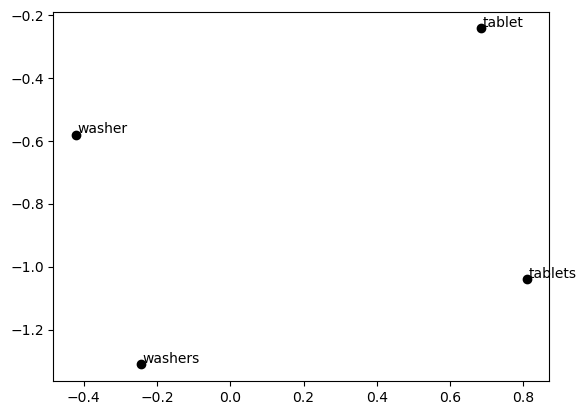

In [51]:
import matplotlib.pyplot as plt

iid = 3
for i in range(4):
    plt.scatter(embdss[good_id[iid]][i][0], embdss[good_id[iid]][i][1], color='black')
    plt.text(embdss[good_id[iid]][i][0] + 0.005, embdss[good_id[iid]][i][1] + 0.005, wordss[good_id[iid]][i])

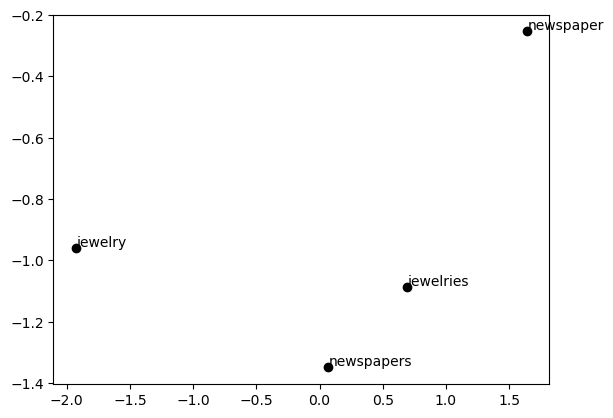

In [52]:
import matplotlib.pyplot as plt

iid = -10

for i in range(4):
    plt.scatter(embdss[bad_id[iid]][i][0], embdss[bad_id[iid]][i][1], color='black')
    plt.text(embdss[bad_id[iid]][i][0] + 0.005, embdss[bad_id[iid]][i][1] + 0.005, wordss[good_id[iid]][i])

In [72]:
embdss[sorted_id[iid]][i][0]

0.39340308

(-2.1945109128952027, 0.1335979759693146)

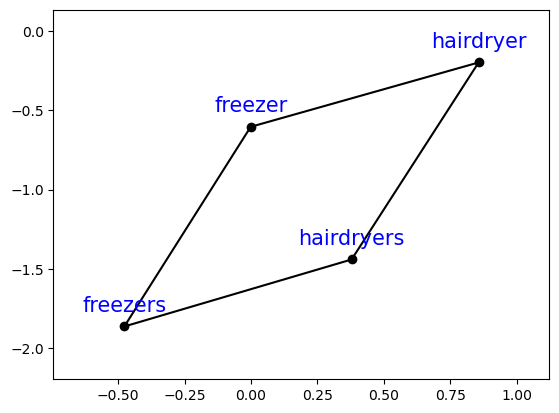

In [99]:
iid = len(trivial_id) + 0

temp = np.min(embdss[sorted_id[iid]], axis=0)
xm = temp[0]; ym = temp[1]
temp = np.max(embdss[sorted_id[iid]], axis=0)
xM = temp[0]; yM = temp[1]

a = 0.2
b = 0.08
xm_plot = xm - (xM - xm) * a
xM_plot = xM + (xM - xm) * a
ym_plot = ym - (yM - ym) * a
yM_plot = yM + (yM - ym) * a

for i in range(4):
    plt.scatter(embdss[sorted_id[iid]][i][0], embdss[sorted_id[iid]][i][1], color='black')
    plt.text(embdss[sorted_id[iid]][i][0], embdss[sorted_id[iid]][i][1] + (yM - ym)*b, wordss[sorted_id[iid]][i], color='blue', horizontalalignment='center', verticalalignment='center', fontsize=15)
    
js = [1,3,0,2]
for i in range(4):
    j = js[i]
    plt.plot([embdss[sorted_id[iid]][i][0], embdss[sorted_id[iid]][j][0]],[embdss[sorted_id[iid]][i][1], embdss[sorted_id[iid]][j][1]], color='black')
    

plt.xlim(xm_plot, xM_plot)
plt.ylim(ym_plot, yM_plot)

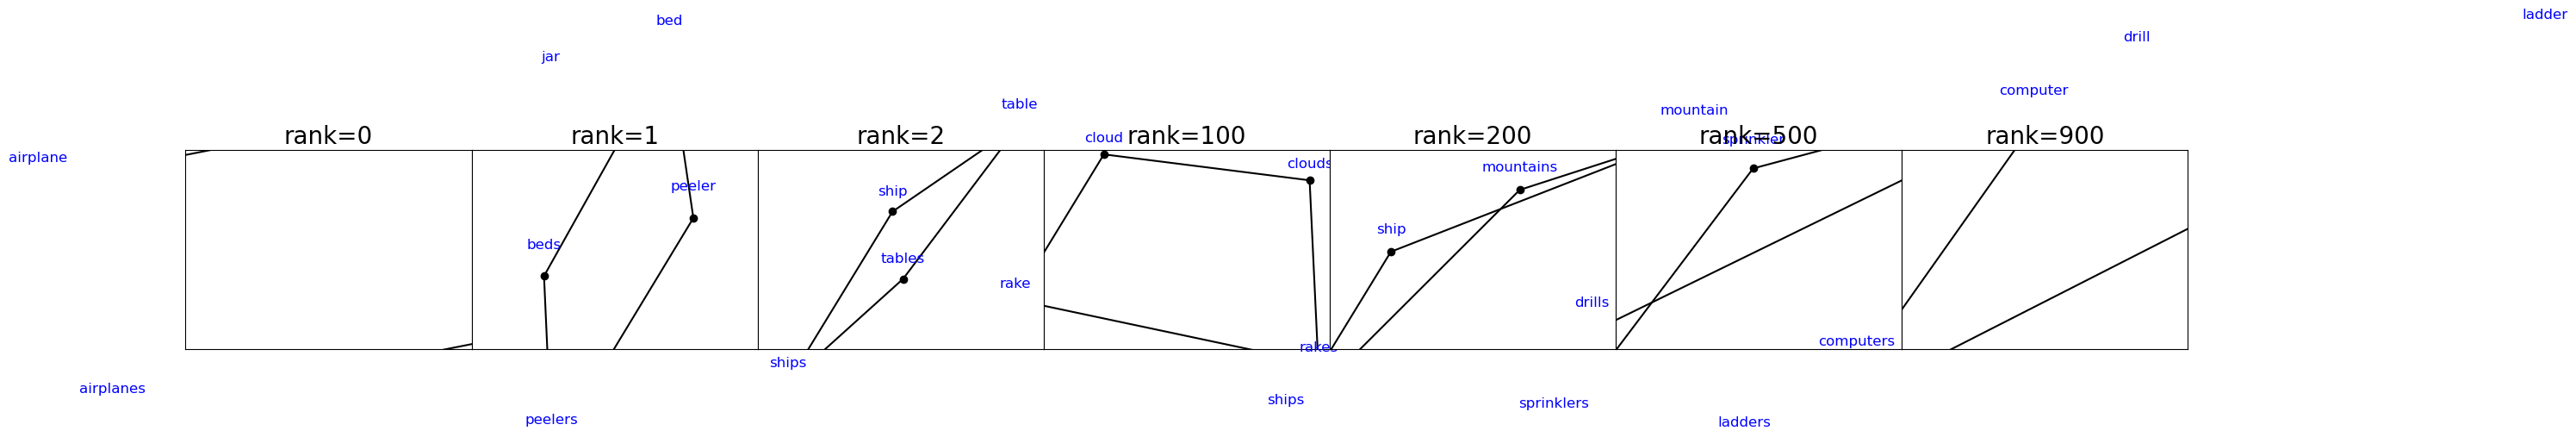

In [162]:
plt.figure(figsize=(30,3))

ranks = [0,1,2,100,200,500,900]

ii = 1

for rank in ranks:
    
    plt.subplot(1,7,ii)

    iid = len(trivial_id) + rank

    temp = np.min(embdss[sorted_id[iid]], axis=0)
    xm = temp[0]; ym = temp[1]
    temp = np.max(embdss[sorted_id[iid]], axis=0)
    xM = temp[0]; yM = temp[1]

    a = 0.4
    b = 0.08
    xm_plot = xm - (xM - xm) * a
    xM_plot = xM + (xM - xm) * a
    ym_plot = ym - (yM - ym) * a
    yM_plot = yM + (yM - ym) * a

    for i in range(4):
        plt.scatter(embdss[sorted_id[iid]][i][0], embdss[sorted_id[iid]][i][1], color='black')
        plt.text(embdss[sorted_id[iid]][i][0], embdss[sorted_id[iid]][i][1] + (yM - ym)*b, wordss[sorted_id[iid]][i], color='blue', horizontalalignment='center', verticalalignment='center', fontsize=12)

    js = [1,3,0,2]
    for i in range(4):
        j = js[i]
        plt.plot([embdss[sorted_id[iid]][i][0], embdss[sorted_id[iid]][j][0]],[embdss[sorted_id[iid]][i][1], embdss[sorted_id[iid]][j][1]], color='black')


    #plt.xlim(xm_plot, xM_plot)
    #plt.ylim(ym_plot, yM_plot)
    temp = np.mean(embdss[sorted_id[iid]], axis=0)
    xmean = temp[0]; ymean = temp[1]
    
    plt.xticks([])
    plt.yticks([])
    plt.xlim(xmean-0.5,xmean+0.5)
    plt.ylim(ymean-0.5,ymean+0.5)
    plt.title("rank=" + str(rank), fontsize=20)
    ii += 1
    
plt.subplots_adjust(wspace=0.0, hspace=0.0)

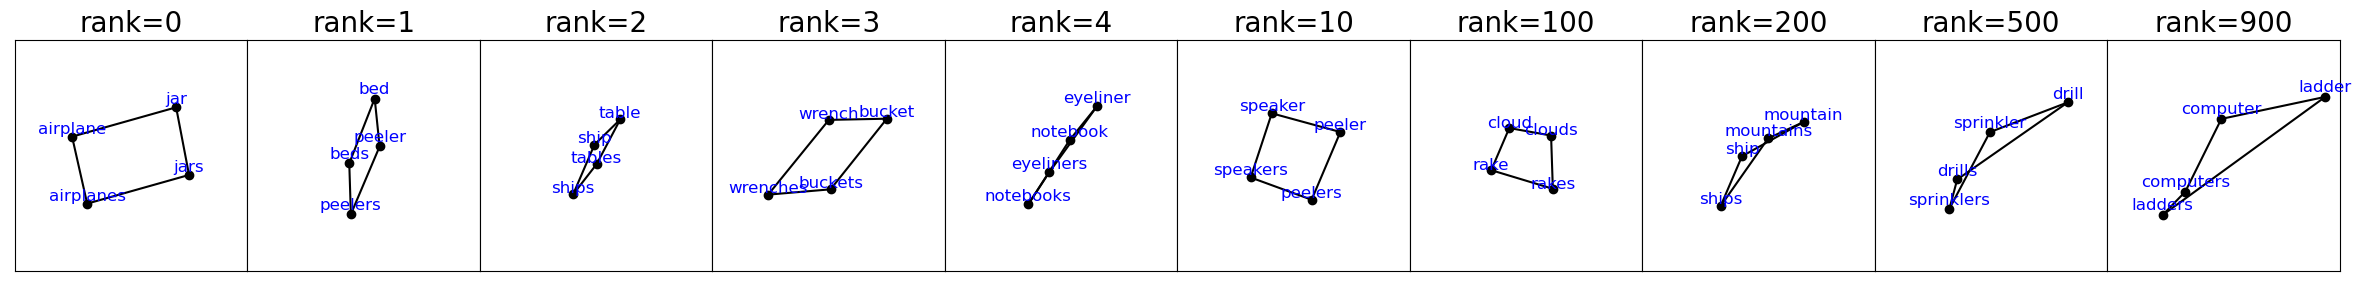

In [160]:
plt.figure(figsize=(30,3))

ranks = [0,1,2,3,4,10,100,200,500,900]

ii = 1

for rank in ranks:
    
    plt.subplot(1,10,ii)

    iid = len(trivial_id) + rank

    temp = np.min(embdss[sorted_id[iid]], axis=0)
    xm = temp[0]; ym = temp[1]
    temp = np.max(embdss[sorted_id[iid]], axis=0)
    xM = temp[0]; yM = temp[1]

    a = 0.4
    b = 0.08
    xm_plot = xm - (xM - xm) * a
    xM_plot = xM + (xM - xm) * a
    ym_plot = ym - (yM - ym) * a
    yM_plot = yM + (yM - ym) * a

    for i in range(4):
        plt.scatter(embdss[sorted_id[iid]][i][0], embdss[sorted_id[iid]][i][1], color='black')
        plt.text(embdss[sorted_id[iid]][i][0], embdss[sorted_id[iid]][i][1] + (yM - ym)*b, wordss[sorted_id[iid]][i], color='blue', horizontalalignment='center', verticalalignment='center', fontsize=12)

    js = [1,3,0,2]
    for i in range(4):
        j = js[i]
        plt.plot([embdss[sorted_id[iid]][i][0], embdss[sorted_id[iid]][j][0]],[embdss[sorted_id[iid]][i][1], embdss[sorted_id[iid]][j][1]], color='black')


    #plt.xlim(xm_plot, xM_plot)
    #plt.ylim(ym_plot, yM_plot)
    temp = np.mean(embdss[sorted_id[iid]], axis=0)
    xmean = temp[0]; ymean = temp[1]
    
    plt.xticks([])
    plt.yticks([])
    plt.xlim(xmean-2,xmean+2)
    plt.ylim(ymean-2,ymean+2)
    plt.title("rank=" + str(rank), fontsize=20)
    ii += 1
    
plt.subplots_adjust(wspace=0.0, hspace=0.0)

In [171]:
arr = list(listdir_nohidden('./abstractive'))
arr

['antonym.json',
 'prev_item.json',
 'capitalize.json',
 'english-german.json',
 'word_length.json',
 'country-capital.json',
 'synonym.json',
 'next_item.json',
 'english-french.json',
 'singular-plural.json',
 'english-spanish.json',
 'present-past.json']

antonym
model_name=standard
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
model_name=harmonic
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
prev_item
model_name=standard
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
model_name=harmonic
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
capitalize
model_name=standard
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
model_name=harmonic
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
english-german
model_name=standard
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
model_name=harmonic
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
word_length
model_name=standard
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
model_name=harmonic
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
country-capital
model_name=standard
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
model_name=harmonic
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
synonym
model_name=standard
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
model_name=harmonic
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
next_item
model_name=standard
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
model_name=harmonic
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
english-french
model_name=standard
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
model_name=harmonic
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
singular-plural
model_name=standard
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
model_name=harmonic
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
english-spanish
model_name=standard
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
model_name=harmonic
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
present-past
model_name=standard
10000
Resuming training from out_small_adam


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M
model_name=harmonic
10000
Resuming training from out_small_adam_hm


/Users/ziming/opt/anaconda3/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


number of parameters: 123.59M


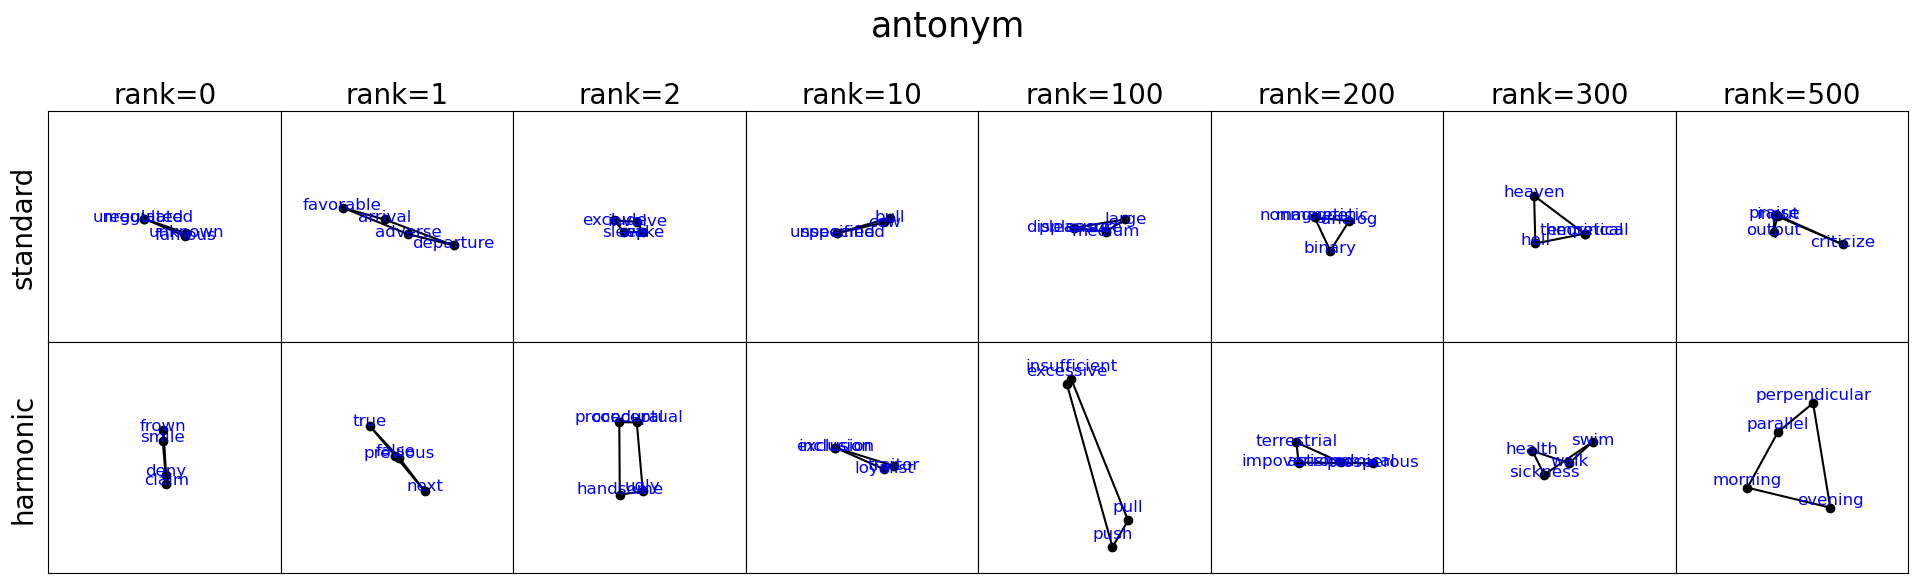

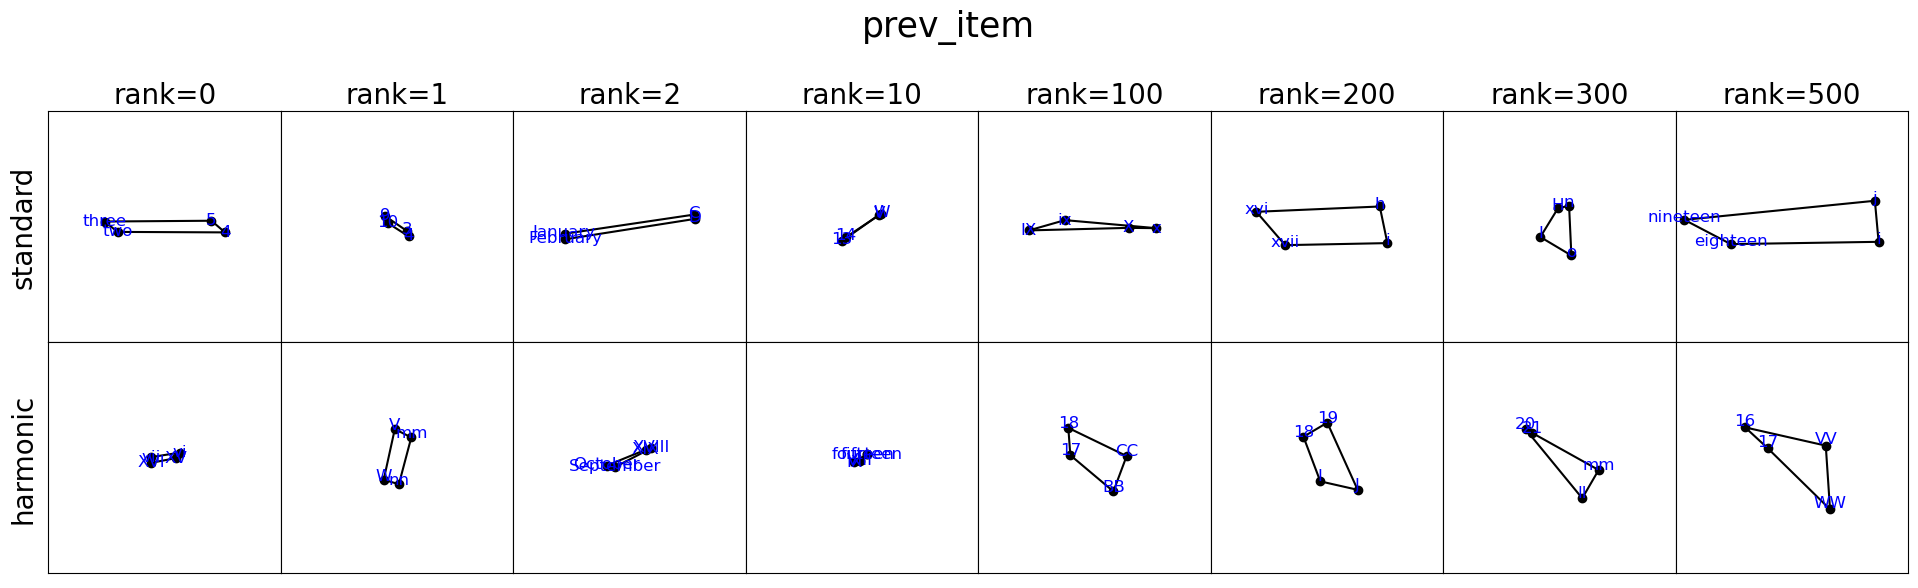

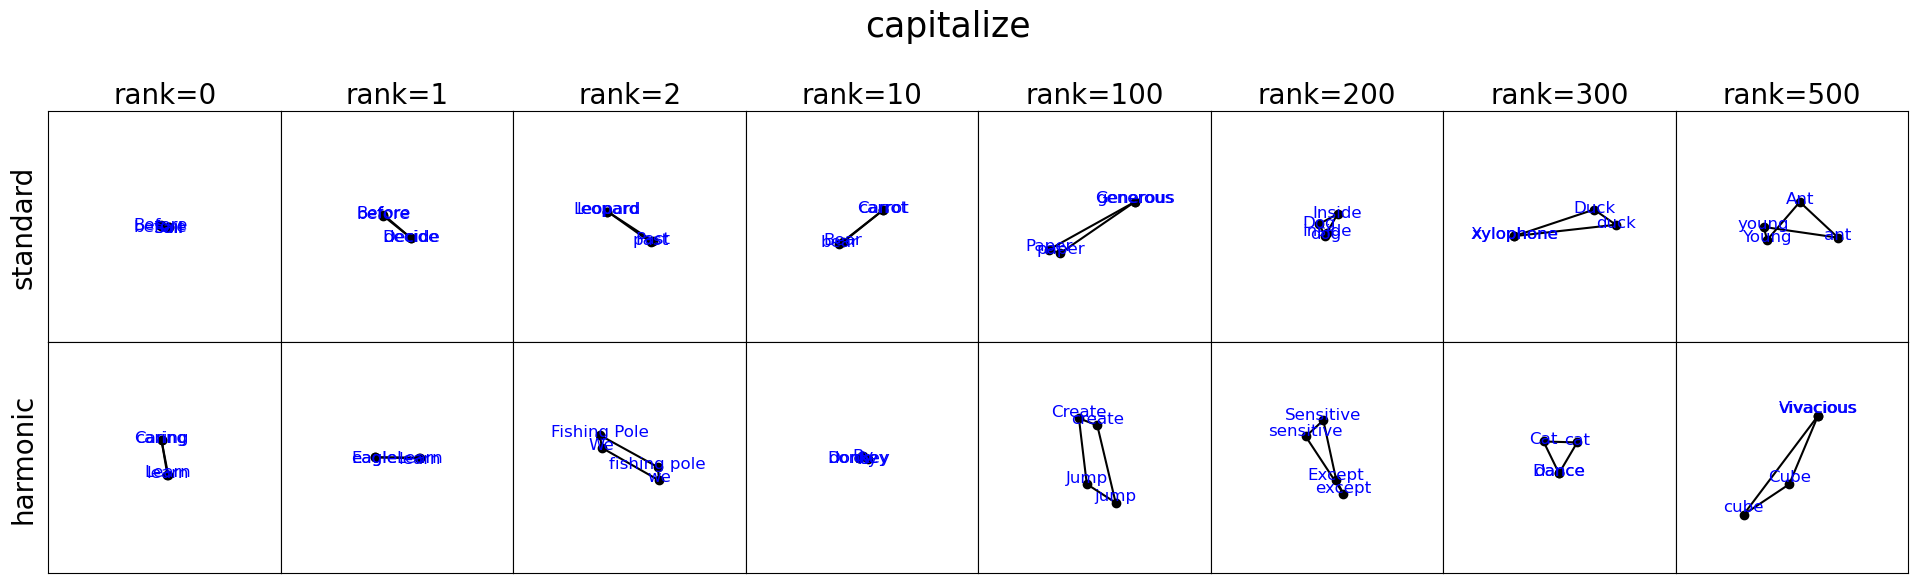

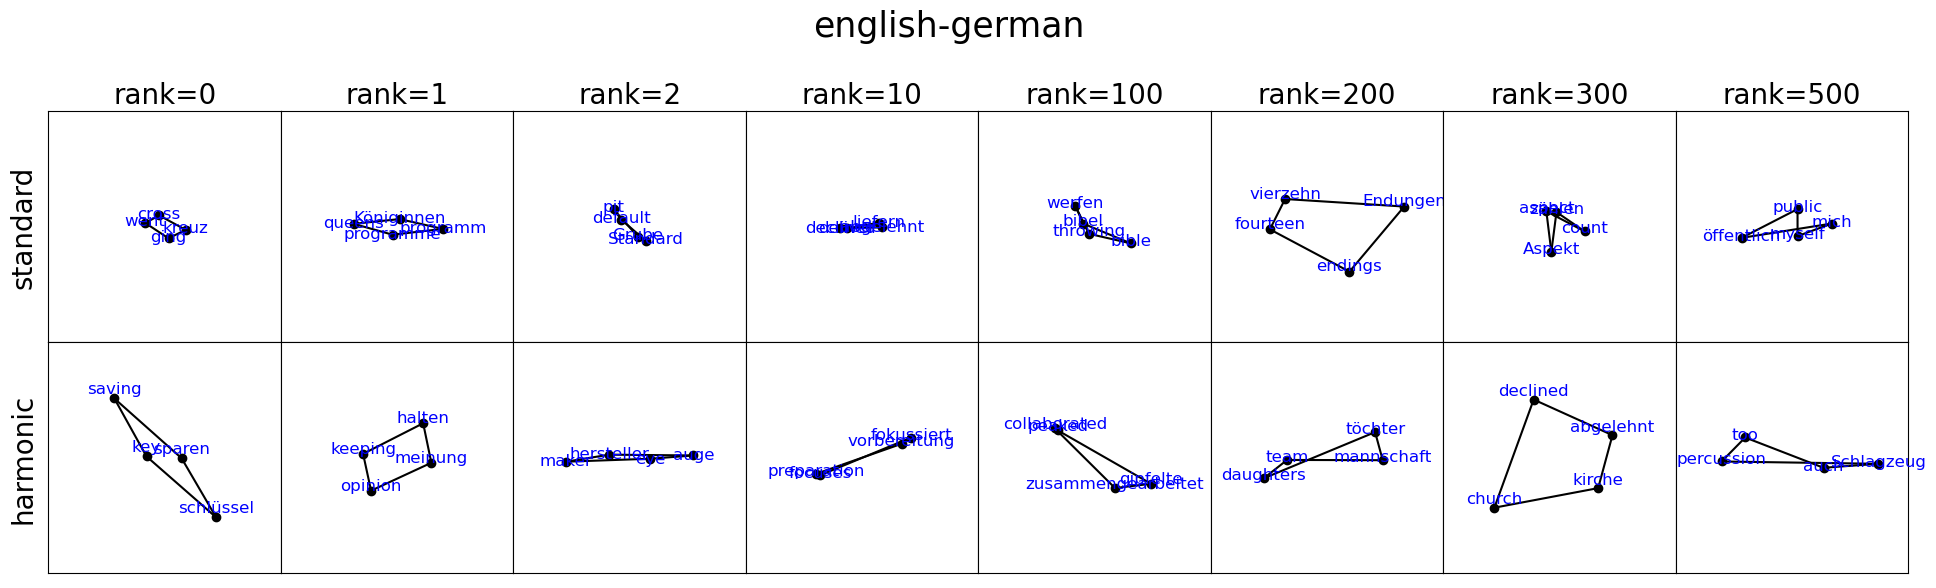

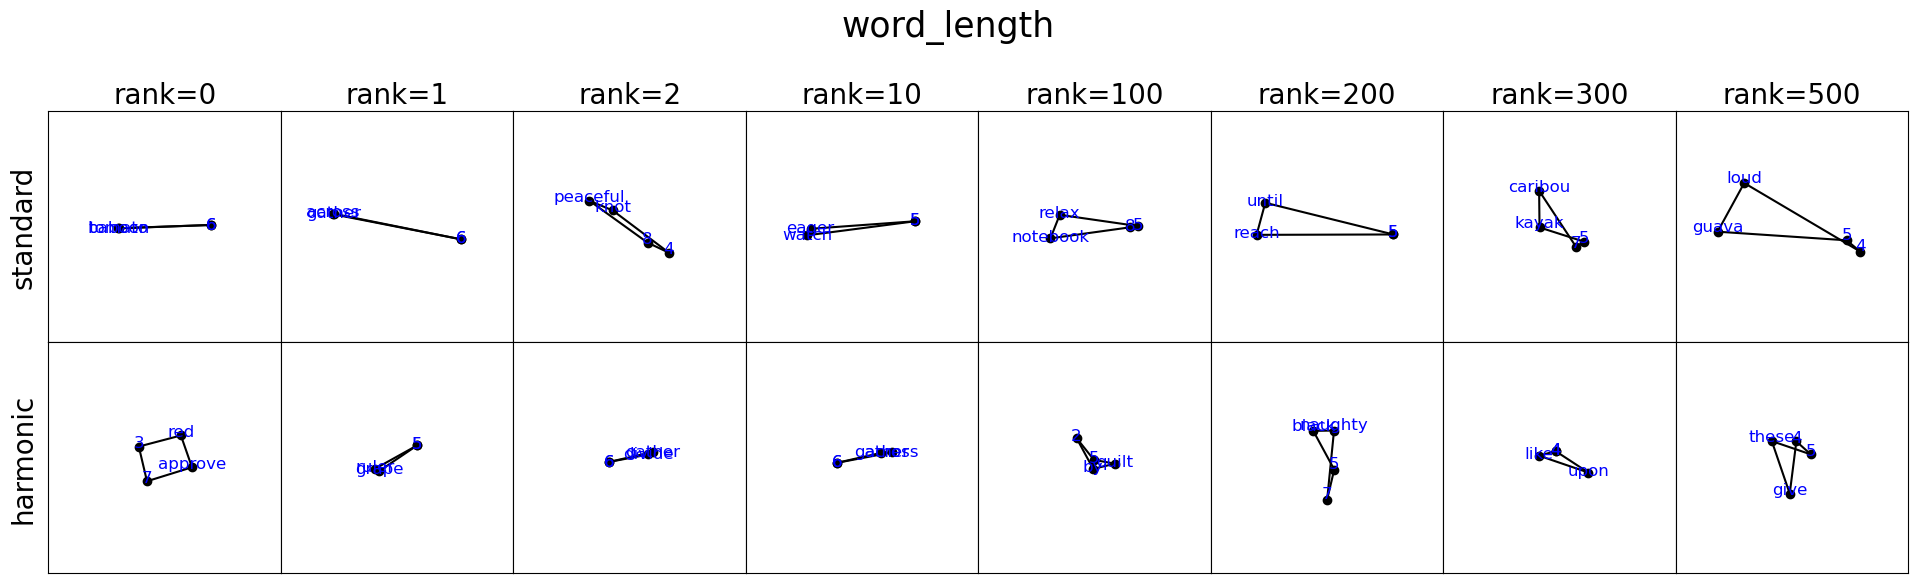

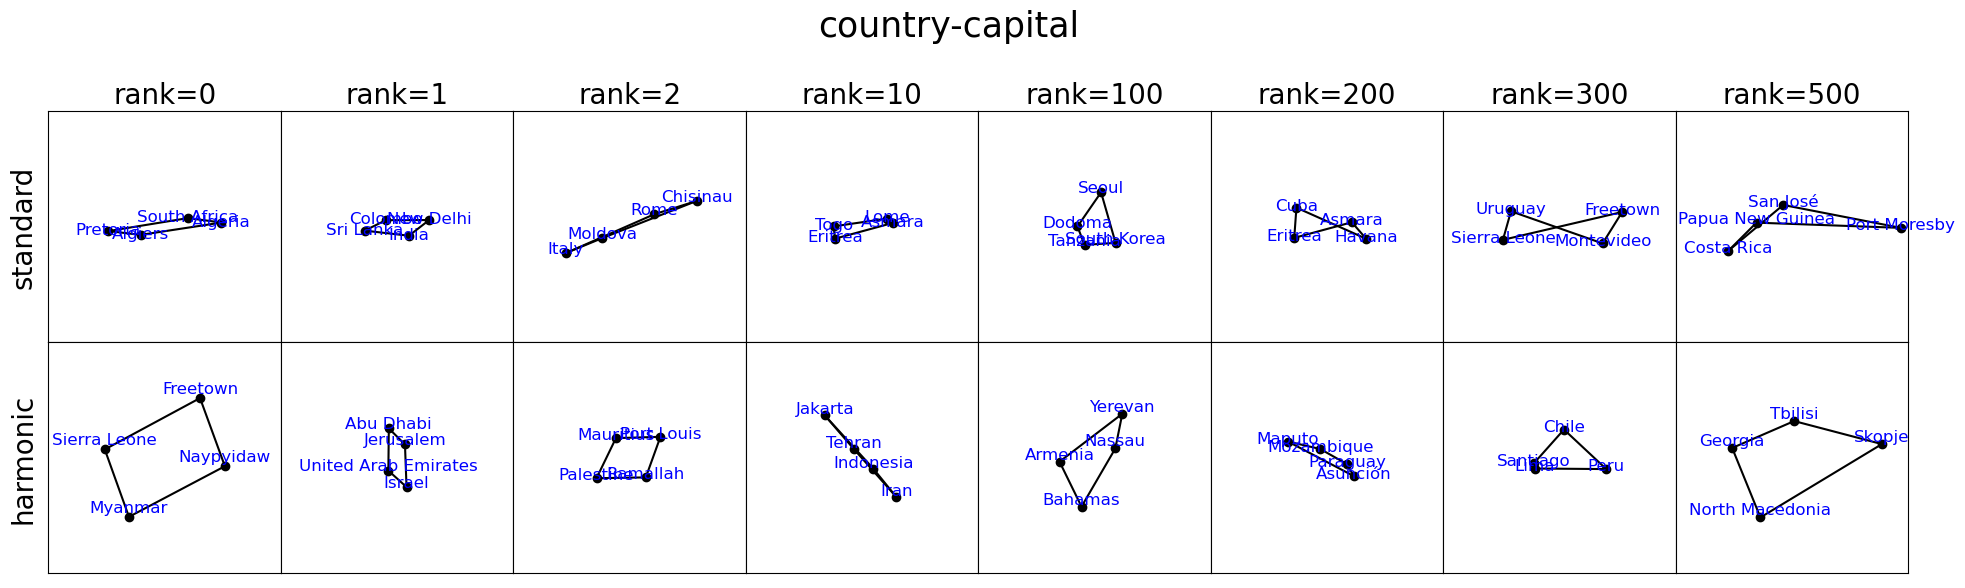

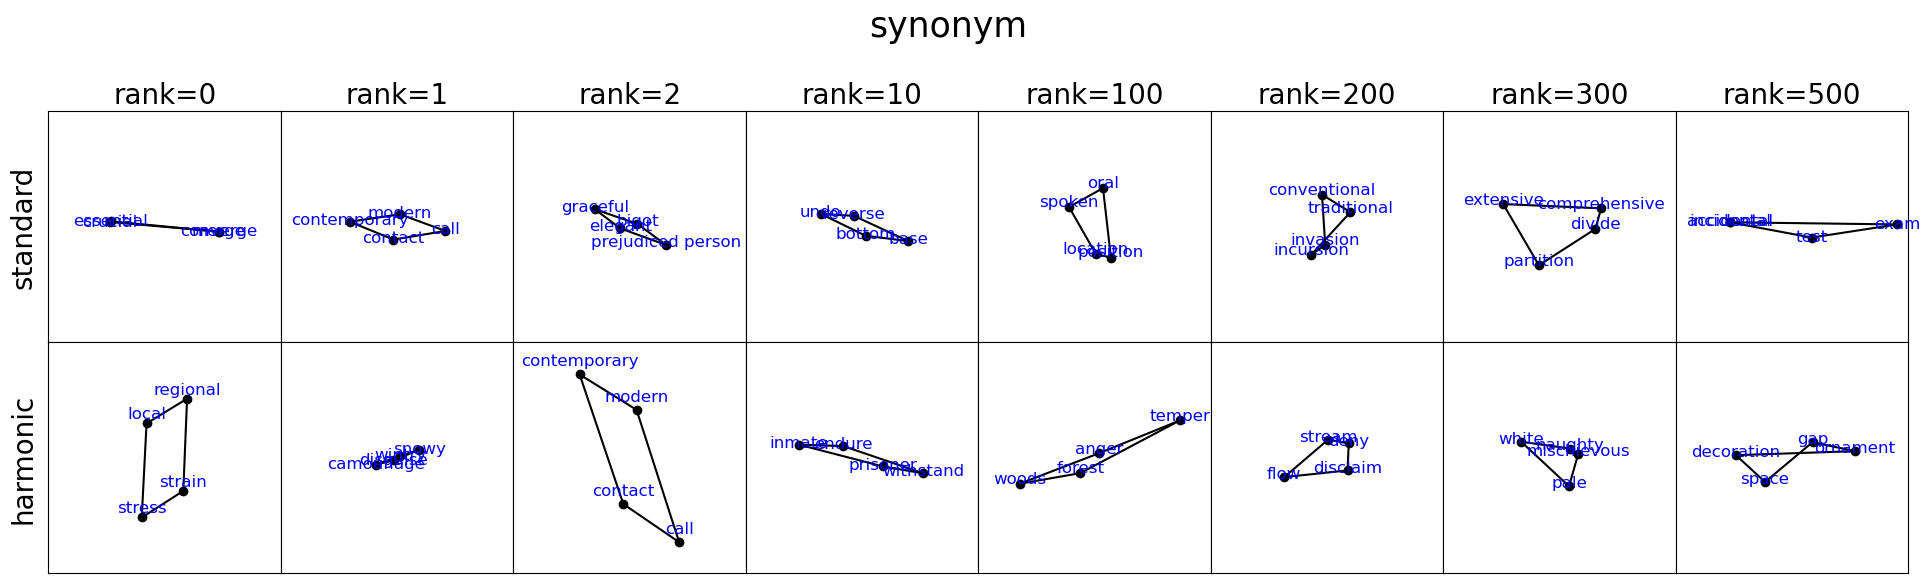

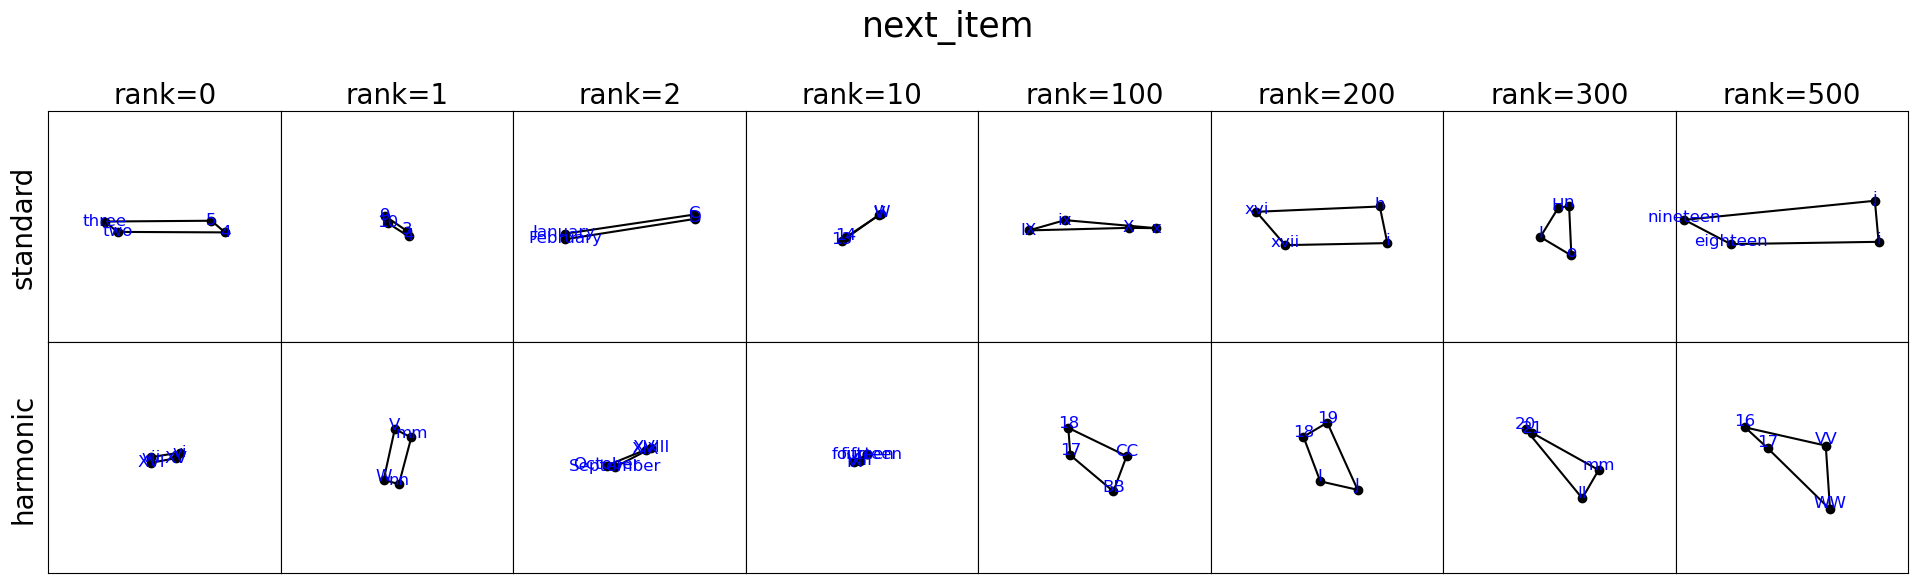

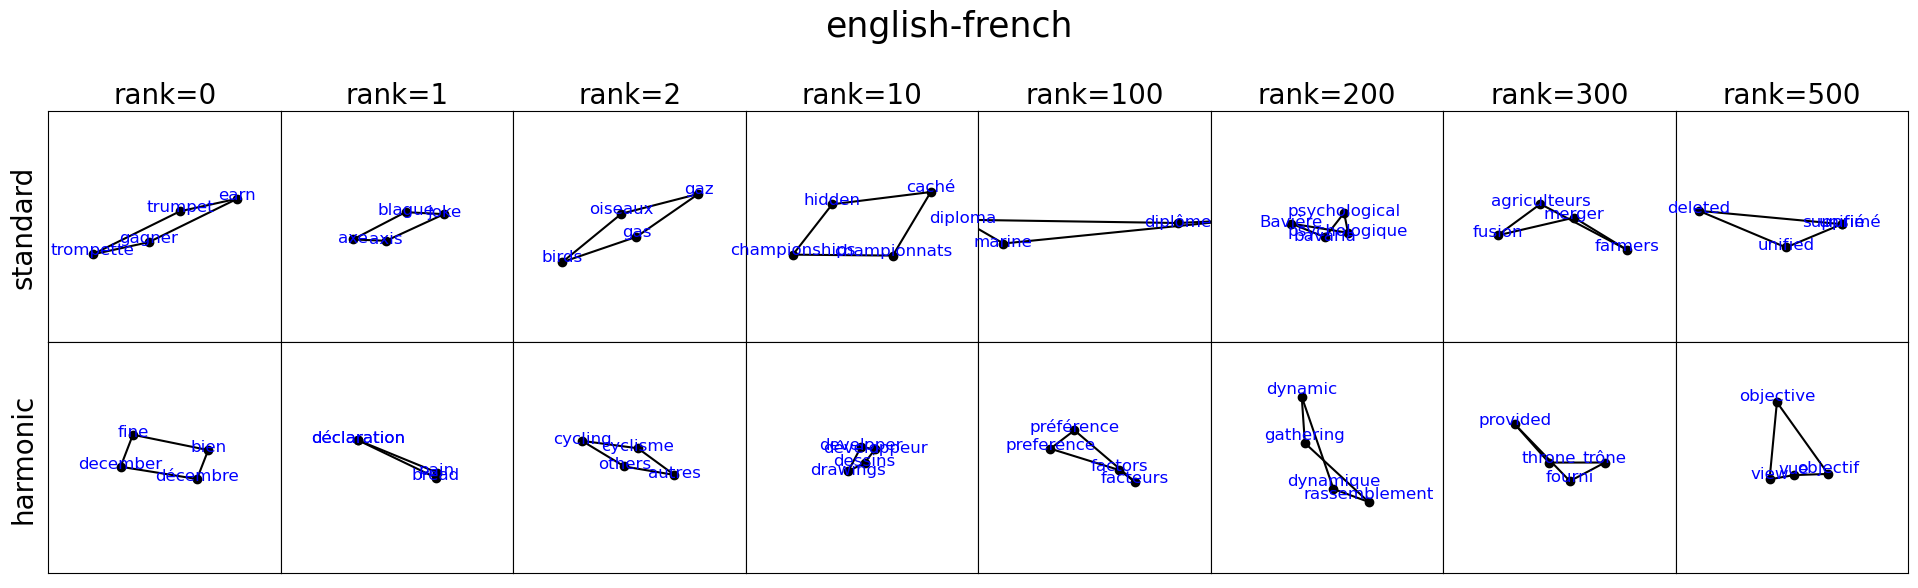

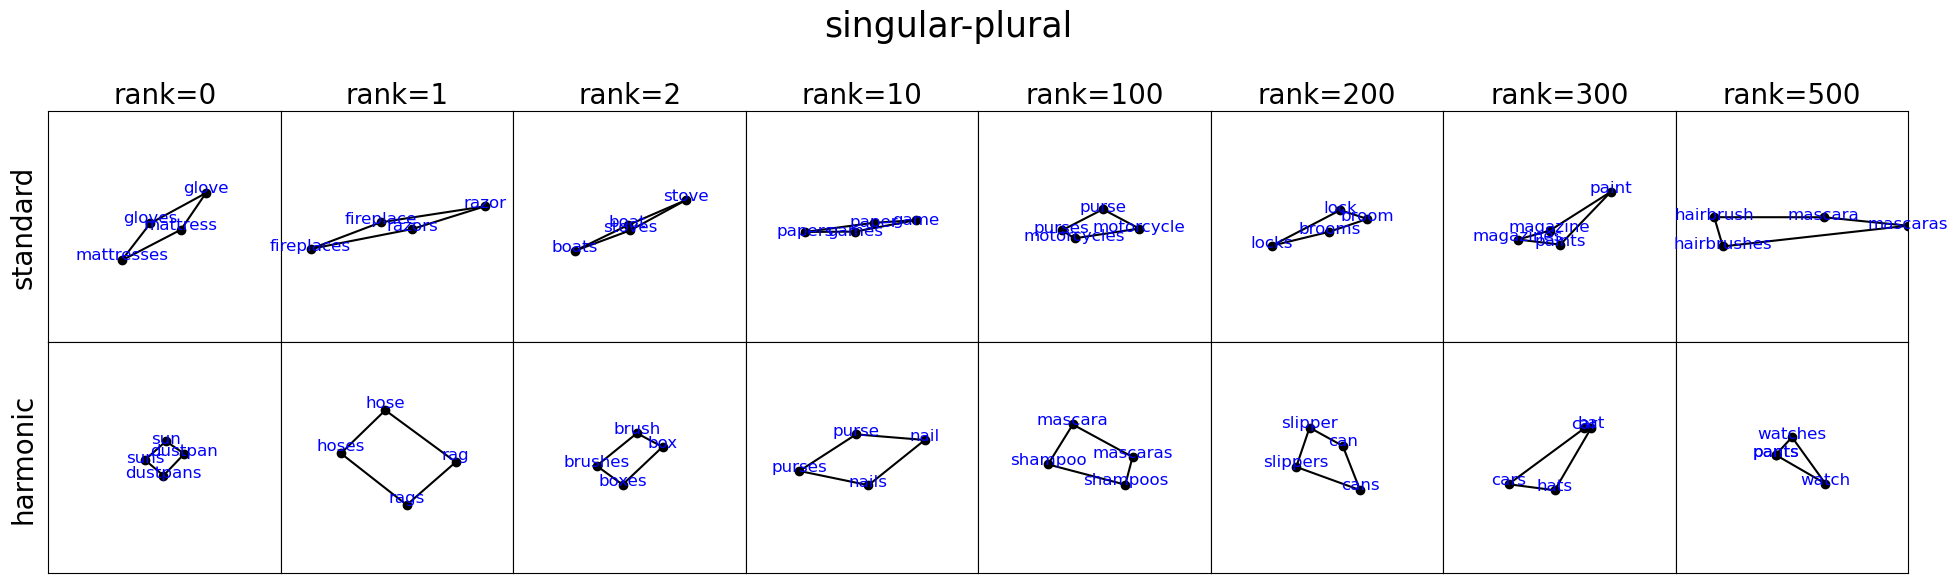

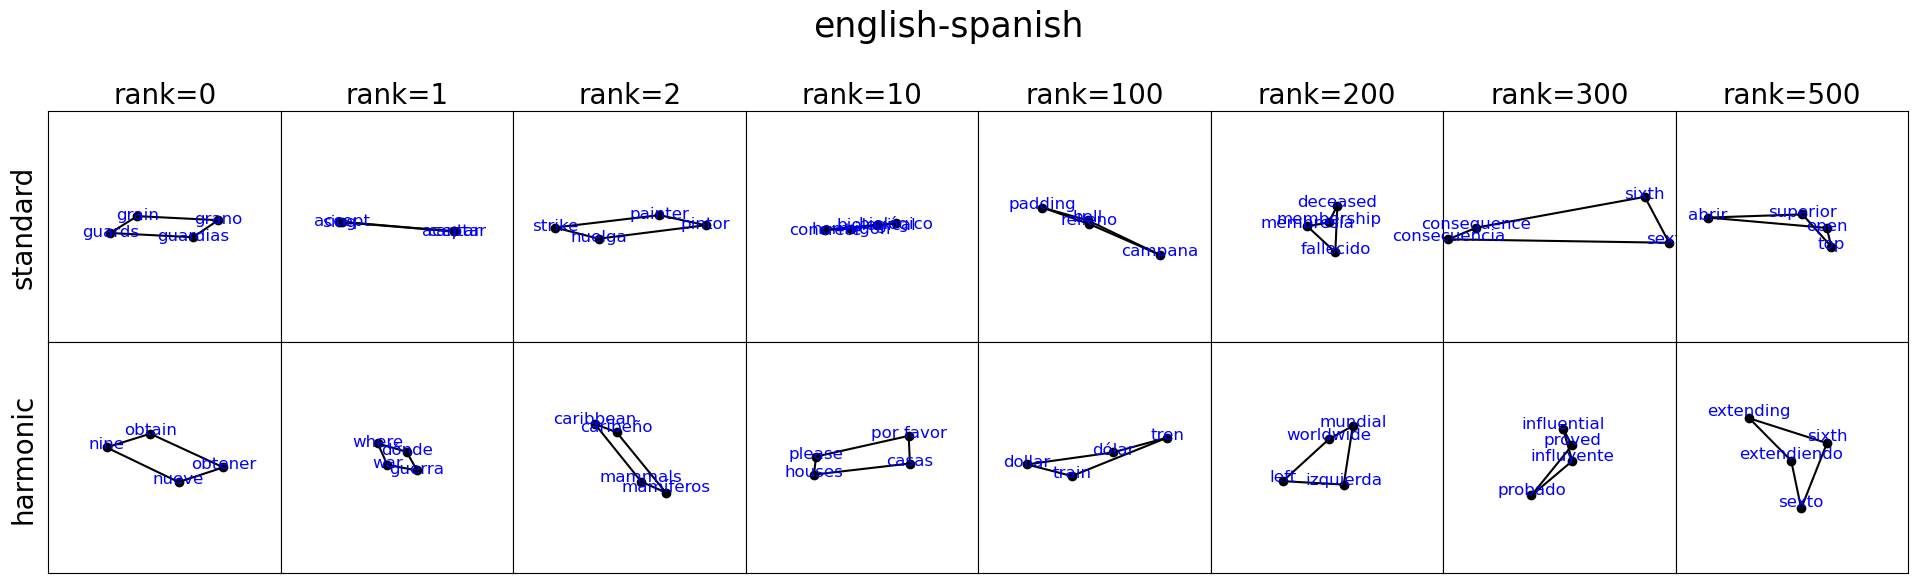

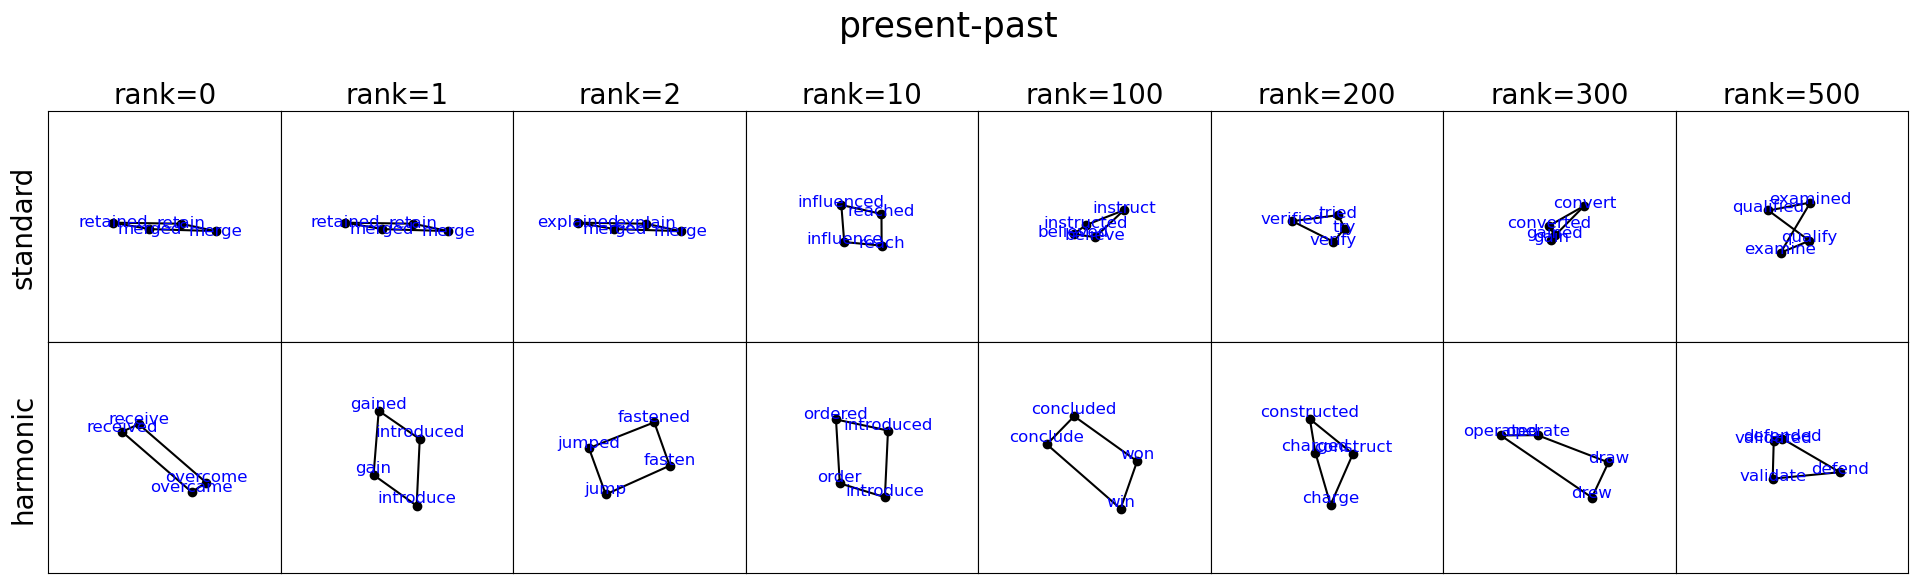

In [4]:
import os
import time
import math
import pickle
from contextlib import nullcontext
import socket
import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group

from model_tmax import GPTConfig, GPT

import warnings
from typing import Union, Iterable, List, Dict, Tuple, Optional

import torch
from torch import Tensor, inf
from torch.utils._foreach_utils import _group_tensors_by_device_and_dtype, _has_foreach_support

import os
import json
import numpy as np
import tiktoken
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

arr = list(listdir_nohidden('./abstractive'))

#arr = ['singular-plural.json']

for task in arr:
    
    task = task[:-5]
    print(task)

    plt.figure(figsize=(24,6))

    model_names = ['standard', 'harmonic']

    for model_name in model_names:

        #model_name = 'standard'
        #model_name = 'harmonic'

        print(f'model_name={model_name}')

        n_components = 2

        enc = tiktoken.get_encoding("gpt2")

        ckpt_step = 10000
        ppp = []

        hostname = socket.gethostname()

        print(ckpt_step)
        # -----------------------------------------------------------------------------
        # default config values designed to train a gpt2 (124M) on OpenWebText
        # I/O
        out_dir = 'out'
        eval_interval = 2000
        log_interval = 1
        eval_iters = 200
        eval_only = False # if True, script exits right after the first eval
        always_save_checkpoint = True # if True, always save a checkpoint after each eval
        init_from = 'scratch' # 'scratch' or 'resume' or 'gpt2*'
        # wandb logging
        wandb_log = False # disabled by default
        wandb_project = 'owt'
        wandb_run_name = 'gpt2' # 'run' + str(time.time())
        os.environ["WANDB_MODE"]="offline" # run wandb offline
        # data
        dataset = 'openwebtext'
        gradient_accumulation_steps = 5 # used to simulate larger batch sizes
        batch_size = 12 # if gradient_accumulation_steps > 1, this is the micro-batch size
        block_size = 1024
        # model
        n_layer = 12
        n_head = 12
        n_embd = 768
        dropout = 0.0 # for pretraining 0 is good, for finetuning try 0.1+
        bias = False # do we use bias inside LayerNorm and Linear layers?
        # optimizer
        optimizer_name = 'adamw' 
        learning_rate = 6e-4 # max learning rate
        max_iters = 600000 # total number of training iterations
        weight_decay = 1e-1
        beta1 = 0.9
        beta2 = 0.95
        grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
        rho = 0.1
        interval = 10
        variant = 4 
        # learning rate decay settings
        decay_lr = True # whether to decay the learning rate
        warmup_iters = 2000 # how many steps to warm up for
        lr_decay_iters = 600000 # should be ~= max_iters per Chinchilla
        min_lr = 6e-5 # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
        # DDP settings
        backend = 'nccl' # 'nccl', 'gloo', etc.
        # system
        device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1' etc., or try 'mps' on macbooks
        dtype = 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
        compile = True # use PyTorch 2.0 to compile the model to be faster
        scale_attn_by_inverse_layer_idx = True
        # -----------------------------------------------------------------------------
        config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]

        wandb_log = True
        wandb_project = 'anneal'
        wandb_run_name='gpt2-small-weightdecay-0-gradclipvalue-1'

        # these make the total batch size be ~0.5M
        # 8 batch size * 1024 block size * 6 gradaccum * 10 GPUs = 491,520
        batch_size = 8
        block_size = 1024
        gradient_accumulation_steps = 6

        n_layer = 12
        n_head = 12
        n_embd = 768
        dropout = 0.0 # for pretraining 0 is good, for finetuning try 0.1+
        bias = False

        # this makes total number of tokens be 300B
        #max_iters = 100000
        max_iters = 10000
        lr_decay_iters = 10000

        # eval stuff
        eval_interval = 1000
        eval_iters = 200
        log_interval = 10

        # optimizer
        optimizer_name = 'adamw'
        learning_rate = 6e-4 # max learning rate
        weight_decay = 0 #1e-1
        beta1 = 0.9
        beta2 = 0.95
        beta3 = 0.
        gamma = 1.
        lr_max = 6e-4
        grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
        # learning rate decay settings
        decay_lr = True # whether to decay the learning rate
        warmup_iters = 2000 # how many steps to warm up for
        #warmup_iters = 0 # how many steps to warm up for
        min_lr = 3e-5 

        compile = True

        if model_name == 'standard':
            out_dir = 'out_small_adam'
        if model_name == 'harmonic':
            out_dir = 'out_small_adam_hm'

        #out_dir = 'out_small_n_28_scale_28_6e-3_3e-4'
        device = 'cpu'

        config = {k: globals()[k] for k in config_keys} # will be useful for logging
        # -----------------------------------------------------------------------------

        # various inits, derived attributes, I/O setup
        ddp = int(os.environ.get('RANK', -1)) != -1 # is this a ddp run?
        if ddp:
            init_process_group(backend=backend)
            ddp_rank = int(os.environ['RANK'])
            ddp_local_rank = int(os.environ['LOCAL_RANK'])
            world_size = int(os.environ["WORLD_SIZE"])
            torch.cuda.set_device(ddp_local_rank)
            print(f"Rank {ddp_rank}: world_size={world_size}, local_rank={ddp_local_rank}, hostname={hostname}")
            master_process = ddp_rank == 0 # this process will do logging, checkpointing etc.
            seed_offset = ddp_rank # each process gets a different seed
            device = torch.device("cuda", ddp_local_rank)
        else:
            # if not ddp, we are running on a single gpu, and one process
            master_process = True
            seed_offset = 0
            gradient_accumulation_steps *= 8 # simulate 8 gpus

        if master_process:
            os.makedirs(out_dir, exist_ok=True)
        torch.manual_seed(5000 + seed_offset)
        torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
        torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
        #device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
        device_type = 'cuda'
        # note: float16 data type will automatically use a GradScaler
        ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
        ctx = nullcontext() if device_type == 'cpu' else torch.autocast(device_type=device_type, dtype=ptdtype)

        # poor man's data loader
        #data_dir = os.path.join('data', dataset)
        data_dir = os.path.join('./')
        #data_dir = './data'
        train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
        val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')
        def get_batch(split):
            data = train_data if split == 'train' else val_data
            ix = torch.randint(len(data) - block_size, (batch_size,))
            x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
            y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
            if device_type == 'cuda':
                # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
                x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
            else:
                x, y = x.to(device), y.to(device)
            return x, y

        # init these up here, can override if init_from='resume' (i.e. from a checkpoint)
        iter_num = 0
        best_val_loss = 1e9

        # attempt to derive vocab_size from the dataset
        meta_path = os.path.join(data_dir, 'meta.pkl')
        meta_vocab_size = None
        if os.path.exists(meta_path):
            with open(meta_path, 'rb') as f:
                meta = pickle.load(f)
            meta_vocab_size = meta['vocab_size']
            print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")

        # model init
        model_args = dict(n_layer=n_layer, n_head=n_head, n_embd=n_embd, block_size=block_size,
                          bias=bias, vocab_size=None, dropout=dropout, scale_attn_by_inverse_layer_idx=scale_attn_by_inverse_layer_idx) # start with model_args from command line


        print(f"Resuming training from {out_dir}")
        # resume training from a checkpoint.
        ckpt_path = os.path.join(out_dir, f'ckpt_{ckpt_step}.pt')
        checkpoint = torch.load(ckpt_path, map_location=device)
        checkpoint_model_args = checkpoint['model_args']
        # force these config attributes to be equal otherwise we can't even resume training
        # the rest of the attributes (e.g. dropout) can stay as desired from command line
        for k in ['n_layer', 'n_head', 'n_embd', 'block_size', 'bias', 'vocab_size']:
            model_args[k] = checkpoint_model_args[k]
        # create the model
        gptconf = GPTConfig(**model_args)
        model = GPT(gptconf)
        state_dict = checkpoint['model']
        # fix the keys of the state dictionary :(
        # honestly no idea how checkpoints sometimes get this prefix, have to debug more
        unwanted_prefix = '_orig_mod.'
        for k,v in list(state_dict.items()):
            if k.startswith(unwanted_prefix):
                state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
        model.load_state_dict(state_dict)
        iter_num = checkpoint['iter_num']
        best_val_loss = checkpoint['best_val_loss']

        def listdir_nohidden(path):
            for f in os.listdir(path):
                if not f.startswith('.'):
                    yield f

        arr = list(listdir_nohidden('./abstractive'))

        scoress = []

        #task = 'singular-plural'



        seed = 1
        np.random.seed(seed)

        with open(f'./abstractive/{task}.json', 'r') as f:
            data = json.load(f)

        p = len(data)

        n_train = 1000

        id1 = np.random.choice(p, n_train)
        id_diff = np.random.choice(p-1, n_train) + 1
        id2 = (id1 + id_diff) % p


        wordss = []

        for i in range(n_train):
            wordss.append([data[id1[i]]['input'],data[id1[i]]['output'], data[id2[i]]['input'],data[id2[i]]['output']])


        embd_model = model.transformer.wte.weight.detach().numpy()
        embd_model = embd_model - np.mean(embd_model, axis=0)[None,:]

        embds_task = []
        for words in wordss:
            for i in range(4):
                true_content = words[i]
                idx = enc.encode(true_content)
                embds_task.append(embd_model[idx[-1]])

        embds_task = np.array(embds_task)

        pca = PCA(n_components=n_components)
        pca.fit(embds_task)

        embd_model_pca = pca.fit_transform(embd_model)
        #embd_model_pca = pca.transform(embd_model)

        scale = np.mean(embd_model_pca**2) * n_components

        scores = []

        embdss = []

        for words in wordss:
            embds = []

            for i in range(4):
                true_content = words[i]
                idx = enc.encode(true_content)
                embds.append(embd_model_pca[idx[-1]])

            embds = np.array(embds)
            score = np.linalg.norm(embds[0] + embds[3] - (embds[1] + embds[2]))**2/scale
            scores.append(score)
            embdss.append(embds)

        embdss = np.array(embdss)

        trivial_id = np.where(np.array(scores) == 0)[0]
        good_id = np.argsort(np.array(scores))[:100]
        good_id = np.array(list(set(good_id) - set(trivial_id)))
        bad_id = np.argsort(np.array(scores))[-100:]
        sorted_id = np.argsort(np.array(scores))

        '''if model_name == 'harmonic':
            np.save(f'./fv_hm_{n_components}pc', np.array(scoress))
        if model_name == 'standard':
            np.save(f'./fv_ce_{n_components}pc', np.array(scoress))'''

        if model_name == 'standard':

            ranks = [0,1,2,10,100,200,300,500]

            ii = 1

            for rank in ranks:

                plt.subplot(2,8,ii)

                iid = len(trivial_id) + rank

                temp = np.min(embdss[sorted_id[iid]], axis=0)
                xm = temp[0]; ym = temp[1]
                temp = np.max(embdss[sorted_id[iid]], axis=0)
                xM = temp[0]; yM = temp[1]

                a = 0.4
                b = 0.08
                xm_plot = xm - (xM - xm) * a
                xM_plot = xM + (xM - xm) * a
                ym_plot = ym - (yM - ym) * a
                yM_plot = yM + (yM - ym) * a

                for i in range(4):
                    plt.scatter(embdss[sorted_id[iid]][i][0], embdss[sorted_id[iid]][i][1], color='black')
                    plt.text(embdss[sorted_id[iid]][i][0], embdss[sorted_id[iid]][i][1] + (yM - ym)*b, wordss[sorted_id[iid]][i], color='blue', horizontalalignment='center', verticalalignment='center', fontsize=12)

                js = [1,3,0,2]
                for i in range(4):
                    j = js[i]
                    plt.plot([embdss[sorted_id[iid]][i][0], embdss[sorted_id[iid]][j][0]],[embdss[sorted_id[iid]][i][1], embdss[sorted_id[iid]][j][1]], color='black')


                #plt.xlim(xm_plot, xM_plot)
                #plt.ylim(ym_plot, yM_plot)
                temp = np.mean(embdss[sorted_id[iid]], axis=0)
                xmean = temp[0]; ymean = temp[1]

                plt.xticks([])
                plt.yticks([])
                plt.xlim(xmean-0.5,xmean+0.5)
                plt.ylim(ymean-0.5,ymean+0.5)
                plt.title("rank=" + str(rank), fontsize=20)

                if ii == 1:
                    plt.ylabel('standard', fontsize=20)

                ii += 1



        if model_name == 'harmonic':
            ranks = [0,1,2,10,100,200,300,500]

            ii = 1

            for rank in ranks:

                plt.subplot(2,8,ii+8)

                iid = len(trivial_id) + rank

                temp = np.min(embdss[sorted_id[iid]], axis=0)
                xm = temp[0]; ym = temp[1]
                temp = np.max(embdss[sorted_id[iid]], axis=0)
                xM = temp[0]; yM = temp[1]

                a = 0.4
                b = 0.08
                xm_plot = xm - (xM - xm) * a
                xM_plot = xM + (xM - xm) * a
                ym_plot = ym - (yM - ym) * a
                yM_plot = yM + (yM - ym) * a

                for i in range(4):
                    plt.scatter(embdss[sorted_id[iid]][i][0], embdss[sorted_id[iid]][i][1], color='black')
                    plt.text(embdss[sorted_id[iid]][i][0], embdss[sorted_id[iid]][i][1] + (yM - ym)*b, wordss[sorted_id[iid]][i], color='blue', horizontalalignment='center', verticalalignment='center', fontsize=12)

                js = [1,3,0,2]
                for i in range(4):
                    j = js[i]
                    plt.plot([embdss[sorted_id[iid]][i][0], embdss[sorted_id[iid]][j][0]],[embdss[sorted_id[iid]][i][1], embdss[sorted_id[iid]][j][1]], color='black')


                #plt.xlim(xm_plot, xM_plot)
                #plt.ylim(ym_plot, yM_plot)
                temp = np.mean(embdss[sorted_id[iid]], axis=0)
                xmean = temp[0]; ymean = temp[1]

                plt.xticks([])
                plt.yticks([])
                plt.xlim(xmean-2.5,xmean+2.5)
                plt.ylim(ymean-2.5,ymean+2.5)
                #plt.title("rank=" + str(rank), fontsize=20)

                if ii == 1:
                    plt.ylabel('harmonic', fontsize=20)

                ii += 1
                
    plt.suptitle(task, fontsize=25, y=1.05)

    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    
    plt.savefig(f'./plots/gpt2_para_{task}.pdf', bbox_inches='tight')
    plt.savefig(f'./plots/gpt2_para_{task}.png', bbox_inches='tight')